# Setup

In [ ]:
!pip install fastai==2.7.10
!pip install git+https://github.com/lessw2020/Ranger21.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lessw2020/Ranger21.git to /tmp/pip-req-build-fa8996cj
  Running command git clone -q https://github.com/lessw2020/Ranger21.git /tmp/pip-req-build-fa8996cj
  Created wheel for ranger21: filename=ranger21-0.0.1-py3-none-any.whl size=24734 sha256=ca4582edbfbade84ece995cec24da0556ff961aef4053f1da41f251791eb0593
  Stored in directory: /tmp/pip-ephem-wheel-cache-re2cx_yd/wheels/31/42/43/ea29fca967e54e6001d53a9c7acf2071d33154f26a27b18cb6
Successfully built ranger21


# Processing training data

In [ ]:
from os import listdir

def remove_invalid(df):
    file_names = listdir('data/images')
    return df[df['image_id'].isin(file_names)]

In [ ]:
from fastai.vision.all import *
import pandas as pd

train_df = pd.read_csv('data/train.csv')
train_df = remove_invalid(train_df)


train_db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter=TrainTestSplitter(),
                    get_x=ColReader(0, pref="data/images/"),
                    get_y=ColReader(1, label_delim=' '),
                    item_tfms=Resize(448), # 224
                    batch_tfms=aug_transforms())
print(train_db)
print(train_df)
dls = train_db.dataloaders(train_df, bs=8)

       image_id                 labels
0    img256.jpg    l16 l18 l23 l25 l73
1     img98.jpg         l0 l24 l26 l39
2    img147.jpg                 l14 l3
3    img254.jpg             l2 l25 l29
4    img160.jpg      l0 l32 l38 l40 l6
..          ...                    ...
200  img105.jpg                    l51
201  img198.jpg      l0 l10 l11 l65 l7
202   img82.jpg                     l2
203  img124.jpg   l0 l1 l19 l22 l34 l6
204   img23.jpg  l1 l15 l18 l2 l21 l71

[201 rows x 2 columns]


In [ ]:
labels_df = pd.read_csv('data/labels.csv')
print(labels_df)

   label_id    object
0        l0    people
1        l1     trees
2        l2     grass
3        l3  building
4        l4      snow
..      ...       ...
87      l87     stage
88      l88      book
89      l89     books
90      l90      flag
91      l91      pole

[92 rows x 2 columns]


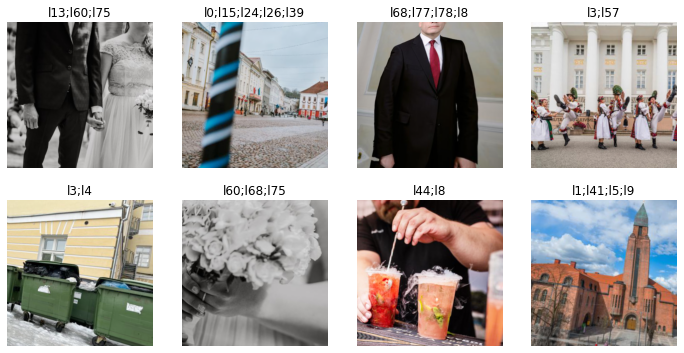

In [ ]:
dls.show_batch(max_n=8, figsize=(12,6))

# The good stuff

In [ ]:
learn = vision_learner(dls, models.resnet34, metrics=accuracy_multi, opt_func=ranger, loss_func=BCEWithLogitsLossFlat())

In [ ]:
class SAM(Callback):
    "Sharpness-Aware Minimization"
    def __init__(self, zero_grad=True, rho=0.05, eps=1e-12, **kwargs): 
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        self.state = defaultdict(dict)
        store_attr()

    def params(self): return self.learn.opt.all_params(with_grad=True)
    def _grad_norm(self): return torch.norm(torch.stack([p.grad.norm(p=2) for p,*_ in self.params()]), p=2)
    
    @torch.no_grad()
    def first_step(self):
        scale = self.rho / (self._grad_norm() + self.eps)
        for p,*_ in self.params():
            self.state[p]["e_w"] = e_w = p.grad * scale
            p.add_(e_w)  # climb to the local maximum "w + e(w)"
        if self.zero_grad: self.learn.opt.zero_grad()
        
    @torch.no_grad()    
    def second_step(self):
        for p,*_ in self.params(): p.sub_(self.state[p]["e_w"])

    def before_step(self, **kwargs):
        self.first_step()
        self.learn.pred = self.model(*self.xb); self.learn('after_pred')
        self.loss_func(self.learn.pred, *self.yb).backward()
        self.second_step()

In [ ]:
learn.fit_one_cycle(100, cbs=[SAM()])

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.072071,0.873581,0.513521,00:12
1,1.058694,0.947612,0.499205,00:12
2,1.058217,0.917738,0.513256,00:12
3,1.052157,0.902526,0.510074,00:12
4,1.049624,0.899984,0.521739,00:12
5,1.038578,0.889791,0.515377,00:12
6,1.034319,0.863247,0.517762,00:12
7,1.023050,0.903586,0.507953,00:12
8,1.020441,0.889533,0.539237,00:12
9,1.011595,0.907267,0.522269,00:12


In [ ]:
test_df = pd.read_csv('data/test.csv')
print(test_df)

      image_id
0   img102.jpg
1   img103.jpg
2    img11.jpg
3   img113.jpg
4   img114.jpg
..         ...
83   img81.jpg
84   img84.jpg
85   img90.jpg
86   img93.jpg
87   img94.jpg

[88 rows x 1 columns]


image_id    img69.jpg
labels      l0 l1 l41
Name: 77, dtype: object


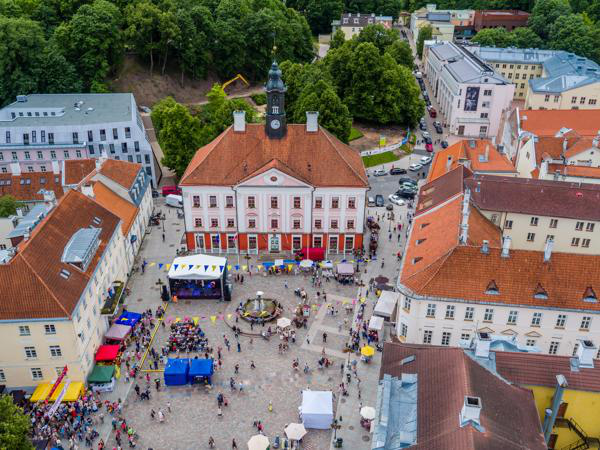

In [ ]:
img_series = test_df.sample().iloc[0]
print(img_series)

img_path = 'data/images/' + img_series['image_id']

img = load_image(img_path)
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img_path)
list(map(lambda label: labels_df.loc[labels_df['label_id'] == label], pred_class))

[]

In [ ]:
file_names = listdir('data/images')
for i in test_df.index:
  if test_df.at[i, 'image_id'] in file_names:
    img_path = 'data/images/' + test_df.at[i, 'image_id']
    print(img_path)
    pred_class,pred_idx,outputs = learn.predict(img_path)
    print(pred_class)
    test_df.at[i, 'labels'] = ' '.join(pred_class)
  else:
    test_df.at[i, 'labels'] = ''
print(test_df)

data/images/img102.jpg


['l1']
data/images/img103.jpg


['l0', 'l1', 'l10', 'l2']
data/images/img11.jpg


[]
data/images/img113.jpg


['l0']
data/images/img114.jpg


['l0', 'l1']
data/images/img121.jpg


['l0', 'l1']
data/images/img126.jpg


['l0', 'l1', 'l2']
data/images/img131.jpg


['l8']
data/images/img136.jpg


[]
data/images/img137.jpg


['l1', 'l2']
data/images/img139.jpg


['l1', 'l3']
data/images/img140.jpg


['l0', 'l1', 'l22']
data/images/img15.jpg


[]
data/images/img150.jpg


[]
data/images/img151.jpg


['l1']
data/images/img152.jpg


[]
data/images/img156.jpg


['l1', 'l5']
data/images/img161.jpg


['l1', 'l2', 'l9']
data/images/img166.jpg


['l1']
data/images/img167.jpg


['l2']
data/images/img170.jpg


['l0', 'l1']
data/images/img173.jpg


[]
data/images/img176.jpg


[]
data/images/img18.jpg


['l1', 'l2']
data/images/img180.jpg


['l1']
data/images/img181.jpg


['l0', 'l1', 'l10', 'l2']
data/images/img182.jpg


['l0', 'l1']
data/images/img183.jpg


['l0', 'l1']
data/images/img189.jpg


['l1', 'l32', 'l6']
data/images/img192.jpg


['l0']
data/images/img194.jpg


['l2']
data/images/img195.jpg


[]
data/images/img206.jpg


['l0', 'l1', 'l10', 'l2']
data/images/img208.jpg


[]
data/images/img209.jpg


['l1', 'l10', 'l2']
data/images/img211.jpg


['l1', 'l2']
data/images/img212.jpg


['l0', 'l10', 'l2']
data/images/img218.jpg


['l30', 'l36', 'l47', 'l70', 'l78', 'l8', 'l88']
data/images/img22.jpg


['l1', 'l2', 'l7']
data/images/img221.jpg


[]
data/images/img228.jpg


['l1', 'l5', 'l7']
data/images/img230.jpg


['l1', 'l3', 'l9']
data/images/img231.jpg


['l1', 'l4']
data/images/img234.jpg


['l1', 'l9']
data/images/img238.jpg


['l0']
data/images/img243.jpg


['l1', 'l2', 'l9']
data/images/img247.jpg


['l0', 'l1']
data/images/img248.jpg


['l0']
data/images/img249.jpg


['l0']
data/images/img250.jpg


[]
data/images/img251.jpg


['l1']
data/images/img252.jpg


['l0']
data/images/img257.jpg


['l1', 'l9']
data/images/img259.jpg


[]
data/images/img262.jpg


[]
data/images/img265.jpg


['l25', 'l29']
data/images/img266.jpg


[]
data/images/img279.jpg


['l53']
data/images/img280.jpg


[]
data/images/img281.jpg


['l6']
data/images/img292.jpg


['l1']
data/images/img296.jpg


[]
data/images/img3.jpg


['l0', 'l4']
data/images/img300.jpg


['l0', 'l1', 'l7']
data/images/img33.jpg


['l1']
data/images/img37.jpg


['l1']
data/images/img39.jpg


[]
data/images/img41.jpg


['l1']
data/images/img42.jpg


[]
data/images/img43.jpg


[]
data/images/img48.jpg


['l4']
data/images/img49.jpg


[]
data/images/img5.jpg


['l0', 'l17', 'l4', 'l58', 'l63', 'l79']
data/images/img57.jpg


['l8']
data/images/img59.jpg


['l1']
data/images/img69.jpg


['l0', 'l1', 'l3', 'l7']
data/images/img71.jpg


[]
data/images/img73.jpg


['l1', 'l3']
data/images/img75.jpg


['l0']
data/images/img79.jpg


['l0', 'l1', 'l2']
data/images/img8.jpg


['l0', 'l17', 'l4', 'l58', 'l63']
data/images/img81.jpg


['l2', 'l6']
data/images/img84.jpg


[]
data/images/img90.jpg


['l0', 'l26']
data/images/img93.jpg


['l1', 'l12', 'l33', 'l36', 'l47', 'l55', 'l70', 'l78', 'l8', 'l88']
data/images/img94.jpg


[]
      image_id                                 labels
0   img102.jpg                                     l1
1   img103.jpg                           l0 l1 l10 l2
2    img11.jpg                                       
3   img113.jpg                                     l0
4   img114.jpg                                  l0 l1
..         ...                                    ...
83   img81.jpg                                  l2 l6
84   img84.jpg                                       
85   img90.jpg                                 l0 l26
86   img93.jpg  l1 l12 l33 l36 l47 l55 l70 l78 l8 l88
87   img94.jpg                                       

[88 rows x 2 columns]


In [ ]:
test_df.to_csv('data/submission.csv', index = False)

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kristoisberg","key":"e896f3fc0e72d1ac41b5c41a2585a55a"}'}

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
- path is now set to: {/content}


In [ ]:
!kaggle competitions submit -c tartu-object-detection-part-2 -f data/submission.csv -m "FastAI v2 submission with ranger and SAM"

100% 1.49k/1.49k [00:02<00:00, 676B/s]
400 - Bad Request
